# Imports

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as A
import seaborn as sns

from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score

from keras import Sequential, Input, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Dropout

In [ ]:
def walk_through_dir(filepath):
    for dirpath, dirnames, filenames in os.walk(filepath):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    print()

def get_filetypes(filepath):
    exts = set(os.path.splitext(f)[1] for dir,dirs,files in os.walk(filepath) for f in files)
    print("File extentions on image directory: ", exts)
    return exts

def process_img(filepath):
    filenames = list(Path(filepath).glob(r'**/*{}'.format('jpg')))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filenames))

    filepaths = pd.Series(filenames, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df.sample(frac=1)

# Process Data

In [ ]:
train_path = "/Users/aashigoyal/Desktop/vscode/aashimain/aisd_whole/Data/Canada/train"
test_path = "/Users/aashigoyal/Desktop/vscode/aashimain/aisd_whole/Data/Canada/test"
val_path = "/Users/aashigoyal/Desktop/vscode/aashimain/aisd_whole/Data/Canada/valid"

train_df = process_img(train_path)
val_df = process_img(val_path)
test_df = process_img(test_path)

# Visualize Data

In [ ]:


img = cv2.imread(train_df.iloc[0].Filepath)
INPUT_SHAPE = img.shape
print(INPUT_SHAPE)


(350, 350, 3)


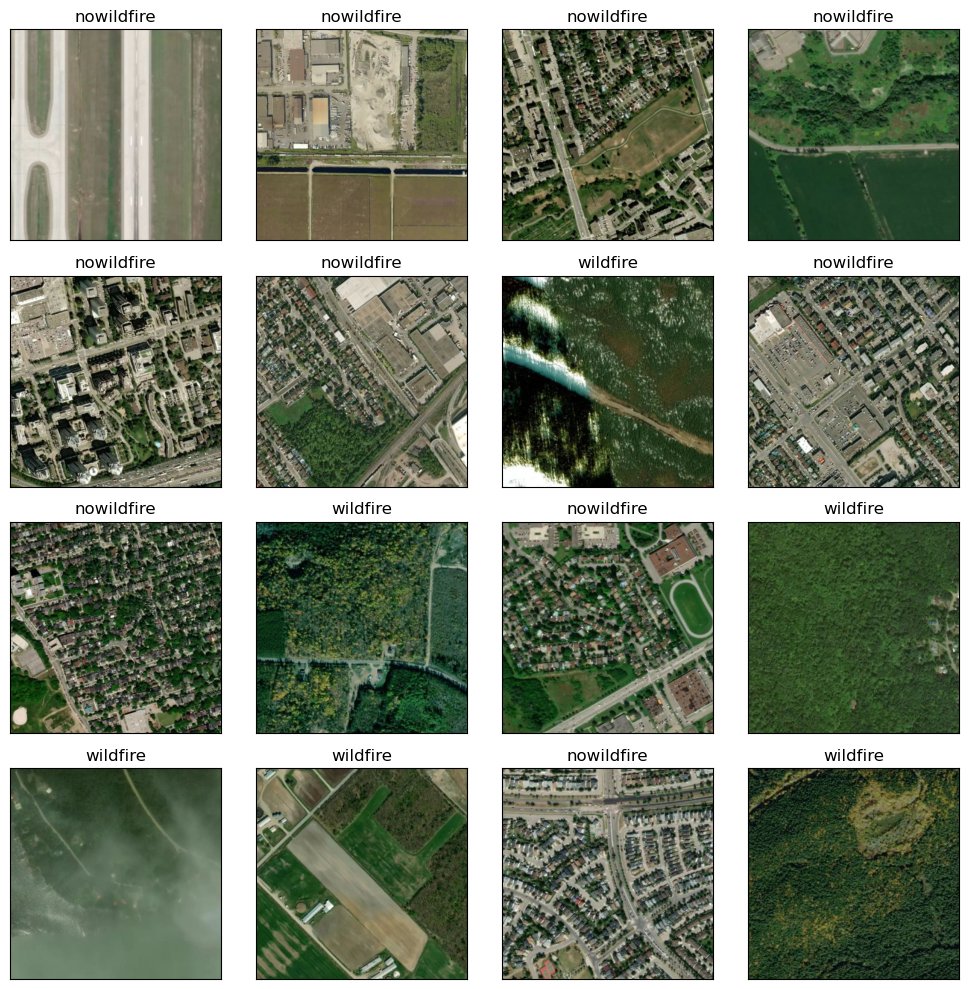

In [ ]:
def show_image_sample(df):
    random_data = df.sample(n=16)
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(random_data.iloc[i].Filepath))
        ax.set_title(random_data.iloc[i].Label)
    plt.tight_layout()
    plt.show()

show_image_sample(train_df)

# Data Augmentation

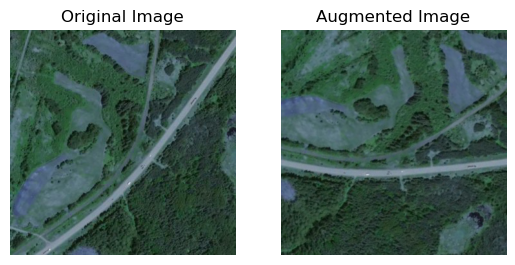

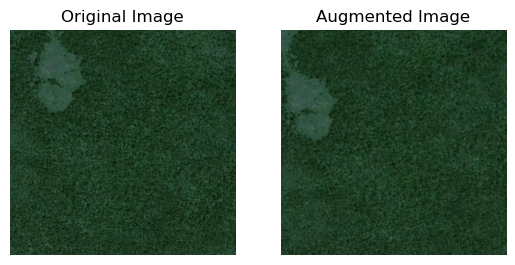

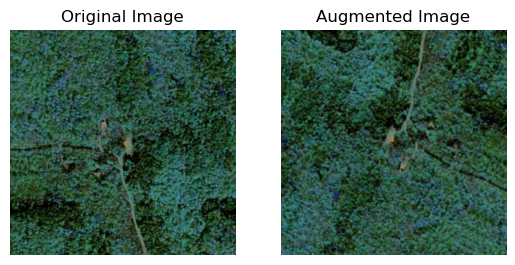

In [ ]:
def augment_image(image):
    aug = A.Compose([
        A.Flip(),
        A.Rotate(limit=75,always_apply=True),
    ])
    augmented_image = aug(image=image)['image']
    return augmented_image


def show_original_augment_image(df):
    random_data = df.sample(n=3)
    for i in range(len(random_data)):
        image = cv2.imread(random_data.iloc[i].Filepath)
        augmented_image = augment_image(image)

        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("Original Image")

        plt.subplot(1,2,2)
        plt.imshow(augmented_image)
        plt.title("Augmented Image")
        plt.axis('off')
        plt.show()

show_original_augment_image(train_df)

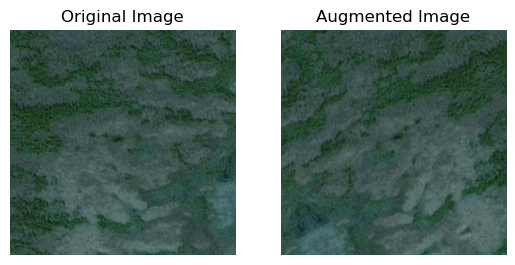

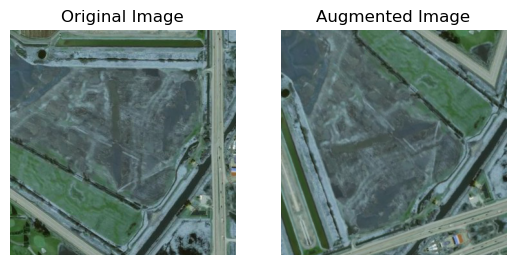

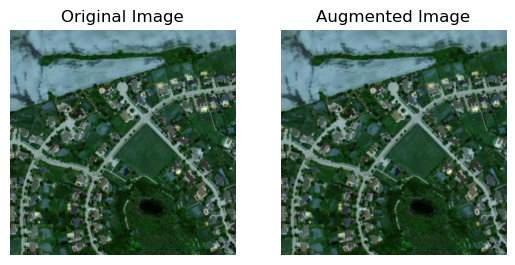

In [ ]:
show_original_augment_image(val_df)

# Creating ImageDataGenerators

In [ ]:
BATCH_SIZE = 256
train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255., preprocessing_function=augment_image)
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=True,
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (350,350),
                                                    class_mode = 'categorical')
val_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
val_generator = val_datagen.flow_from_dataframe(val_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=True,
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (350,350),
                                                    class_mode = 'categorical')
test_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=False,
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (350,350),
                                                    class_mode = 'categorical')

Found 30250 validated image filenames belonging to 2 classes.
Found 6310 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.


# Building our model

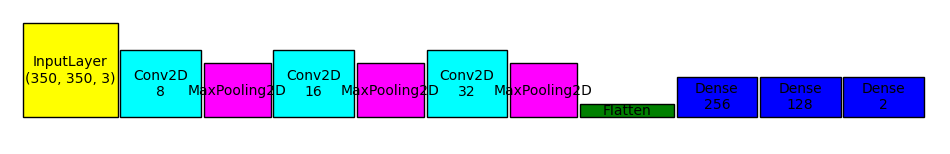

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Define the size of each layer type for drawing
layer_sizes = {
    'InputLayer': (3.5, 3.5),
    'Conv2D': (3, 2.5),
    'MaxPooling2D': (2.5, 2),
    'Flatten': (3.5, 0.5),
    'Dense': (3, 1.5)
}

# Define colors for each layer type
layer_colors = {
    'InputLayer': 'yellow',
    'Conv2D': 'cyan',
    'MaxPooling2D': 'magenta',
    'Flatten': 'green',
    'Dense': 'blue'
}

# Define the sequence of layers in the model architecture
model_layers = [
    ('InputLayer', (350, 350, 3)),
    ('Conv2D', 8),
    ('MaxPooling2D', None),
    ('Conv2D', 16),
    ('MaxPooling2D', None),
    ('Conv2D', 32),
    ('MaxPooling2D', None),
    ('Flatten', None),
    ('Dense', 256),
    ('Dense', 128),
    ('Dense', 2)
]

# Initialize figure and axis
fig, ax = plt.subplots(figsize=(12, 7))

# Starting coordinates
x = 0.5
y = 2

# Draw each layer as a colored rectangle
for layer in model_layers:
    layer_type = layer[0]
    size = layer_sizes[layer_type]
    color = layer_colors[layer_type]
    ax.add_patch(Rectangle((x, y), size[0], size[1], edgecolor='black', facecolor=color))

    # Add text inside the rectangle
    if layer_type != 'MaxPooling2D':  # MaxPooling2D doesn't have a parameter to show
        text = f"{layer_type}\n{layer[1]}" if layer[1] is not None else layer_type
    else:
        text = layer_type
    plt.text(x + size[0]/2, y + size[1]/2, text, ha='center', va='center', color='black', fontsize=10)

    # Update x coordinate for the next layer
    x += size[0] + 0.1  # Add a small space between blocks

# Set the limits, labels and title of the plot
ax.set_xlim(0, x+0.5)
ax.set_ylim(1, 6)
ax.set_aspect('equal')
ax.axis('off')  # Turn off the axis

plt.show()

In [ ]:
inputs = Input(shape=(350, 350, 3))
x = Conv2D(filters = 8, kernel_size=2)(inputs)
x = MaxPooling2D()(x)

x = Conv2D(filters = 16, kernel_size=2)(x)
x = MaxPooling2D()(x)

x = Conv2D(filters = 32, kernel_size=2)(x)
x = MaxPooling2D()(x)

x = Flatten()(x)
x = Dense(256, activation="relu")(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 349, 349, 8)       104       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 174, 174, 8)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 173, 173, 16)      528       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 86, 86, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 85, 85, 32)        2080

# Training our model

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

with tf.device('/GPU:0'):
    model.compile(
        optimizer= 'adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC']
    )
    checkpoint = ModelCheckpoint('model.hdf5',verbose=1, save_best_only= True)
    early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)

    history = model.fit(train_generator,
                        epochs = 50,
                        verbose = 1,
                        validation_data = val_generator,
                        callbacks = [checkpoint, early_stopping])

Epoch 1/50
119/119 [==============================] - ETA: 0s - loss: 0.5562 - accuracy: 0.8763 - auc: 0.9346
Epoch 1: val_loss improved from inf to 0.17063, saving model to model.hdf5
119/119 [==============================] - 195s 2s/step - loss: 0.5562 - accuracy: 0.8763 - auc: 0.9346 - val_loss: 0.1706 - val_accuracy: 0.9322 - val_auc: 0.9790
Epoch 2/50
119/119 [==============================] - ETA: 0s - loss: 0.1976 - accuracy: 0.9220 - auc: 0.9724
Epoch 2: val_loss improved from 0.17063 to 0.16193, saving model to model.hdf5
119/119 [==============================] - 168s 1s/step - loss: 0.1976 - accuracy: 0.9220 - auc: 0.9724 - val_loss: 0.1619 - val_accuracy: 0.9380 - val_auc: 0.9822
Epoch 3/50
119/119 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.9263 - auc: 0.9746
Epoch 3: val_loss did not improve from 0.16193
119/119 [==============================] - 181s 2s/step - loss: 0.1871 - accuracy: 0.9263 - auc: 0.9746 - val_loss: 0.1650 - val_accuracy: 0.

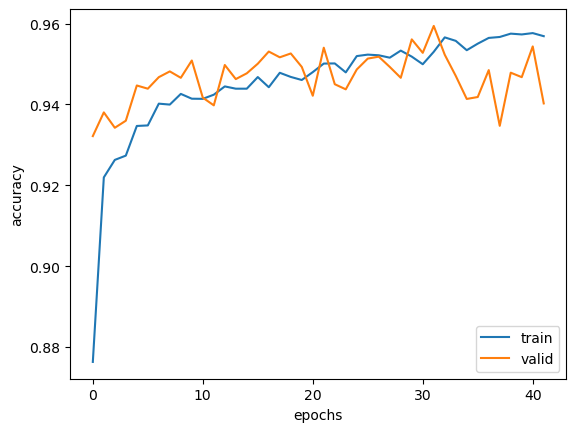

In [ ]:
plt.plot(history.history['accuracy'], label = 'train',)
plt.plot(history.history['val_accuracy'], label = 'valid')

# adding legend and labels
plt.legend(loc = 'lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')

# show the plot
plt.show()

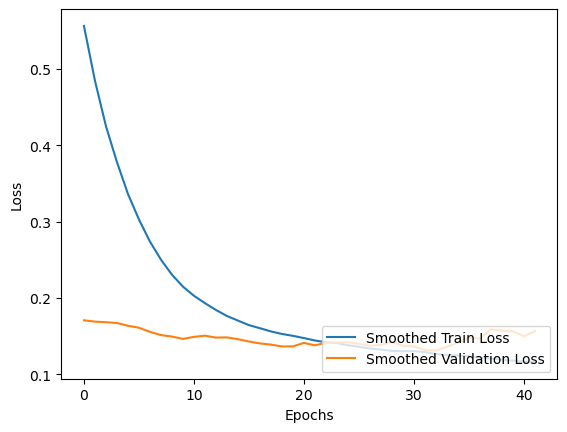

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have history.history['loss'] and history.history['val_loss']

# Smoothing function
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Apply smoothing
smooth_train_loss = smooth_curve(history.history['loss'])
smooth_val_loss = smooth_curve(history.history['val_loss'])

# Plotting
plt.plot(smooth_train_loss, label='Smoothed Train Loss')
plt.plot(smooth_val_loss, label='Smoothed Validation Loss')

# Adding legend and labels
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Show the plot
plt.show()


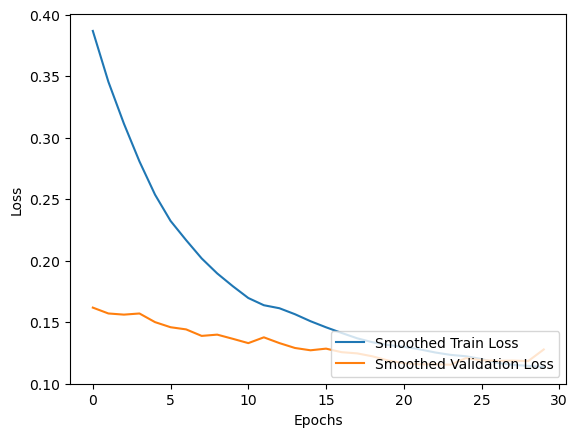

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have history.history['loss'] and history.history['val_loss']

# Smoothing function
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Apply smoothing
smooth_train_loss = smooth_curve(history.history['loss'])
smooth_val_loss = smooth_curve(history.history['val_loss'])

# Plotting
plt.plot(smooth_train_loss, label='Smoothed Train Loss')
plt.plot(smooth_val_loss, label='Smoothed Validation Loss')

# Adding legend and labels
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Show the plot
plt.show()


# Predict

In [ ]:
pred = np.argmax(model.predict(test_generator), axis=1)

25/25 [==============================] - 13s 503ms/step


25/25 [==============================] - 13s 481ms/step
Accuracy: 96.51%
[[2719  101]
 [ 119 3361]]


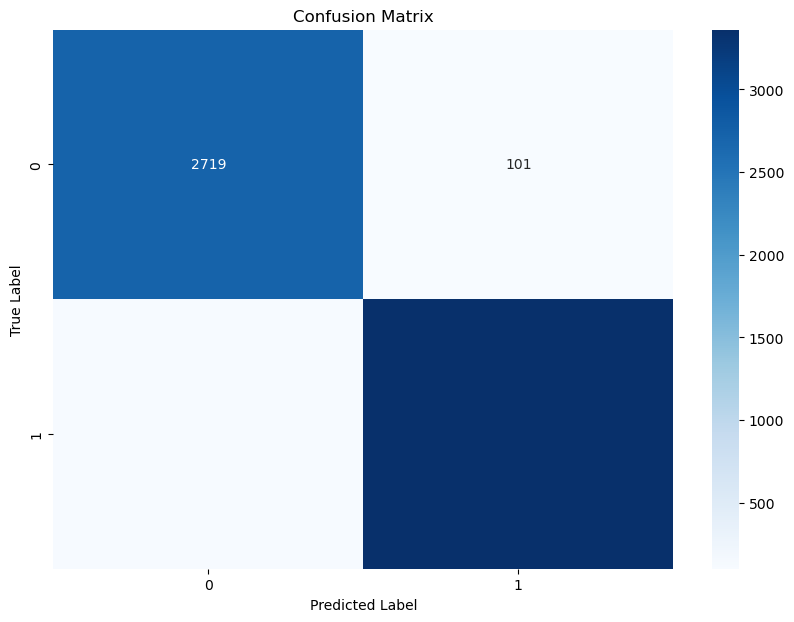

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


model = load_model('model.hdf5')

# Predict the test set
predictions = model.predict(test_generator)

predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes from the test_generator
true_classes = test_generator.classes

# Calculate the accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate the confusion matrix
cf_matrix = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix
print(cf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


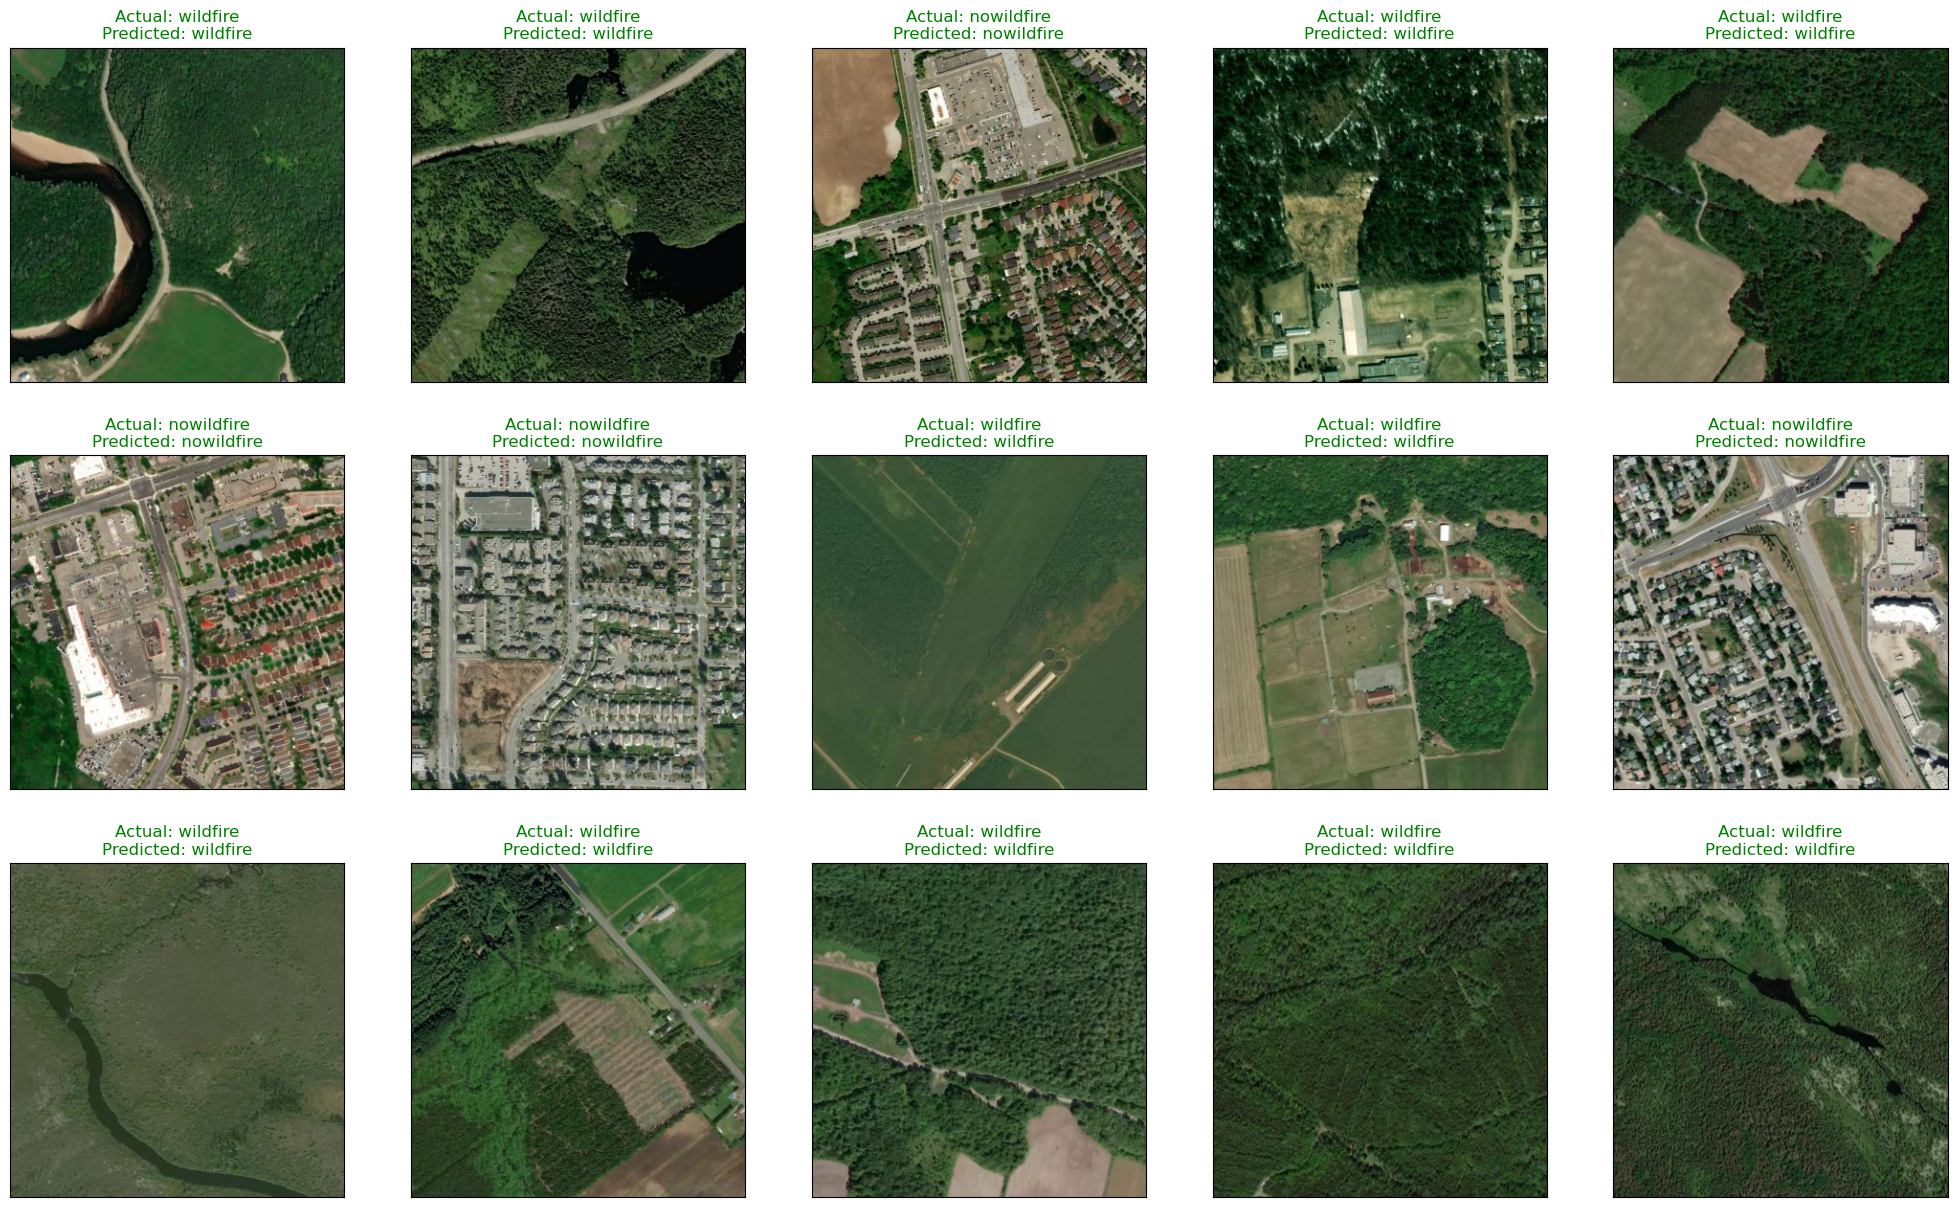

<Figure size 640x480 with 0 Axes>

In [ ]:

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

random_index = np.random.randint(0, len(test_df) - 1, 15)
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_generator.filepaths[random_index[i]]))
    if labels[test_generator.labels[random_index[i]]] == pred_label[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"Actual: {labels[test_generator.labels[random_index[i]]]}\nPredicted: {pred_label[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()